# Advanced RCMES Workflow (with multicore parallelism)

### Import OCW functions

In [1]:
%matplotlib inline
from functions import loadDatasets, temporalRebins, commonLatLonGrid, spatialRegrids
from functions import computeMetrics, contourPlot

### Define the workflow in a simple function

In [2]:
from datetime import timedelta

def compareVariablesWithMetrics(datasetUrls,                    # URL's pointing to datasets, first one is reference, rest are targets
                           variableNames,                       # names of dataset variables, in parallel with first list
                           metrics,                             # list of metrics to compute (by name)
                           outputName,                          # root name for outputs
                           timeRes=timedelta(days=365),         # time resolution to regrid all variables to
                           latRes=1., lonRes=1.,                # lat/lon resolutions to regrid all variables to
                           subregions=None,                     # list of subregion boundaries
                           dir='./'):                           # directory for outputs, defaults to current working dir
    '''Compare multiple target variables to a reference variable, returning the computed metric(s)
after temporally rebinning to a common time resolution and a common spatial (lat/lon) resolution.
    '''
    datasets = loadDatasets(zip(datasetUrls, variableNames), dir)    
    datasets = temporalRebins(datasets, timeRes)
    
    newLats, newLons = commonLatLonGrid(datasets, latRes, lonRes)
    datasets = spatialRegrids(datasets, newLats, newLons)
    
    metrics = computeMetrics(datasets, metrics, subregions)
    return (newLats, newLons, metrics)

### Define a routine to run the workflow (using parallel map for multiple cores)

In [3]:
from multiprocessing import Pool

def run(urls, vars, outputName, nCores=1, **config):
    '''Run compareManyWithMetrics routine.'''
    if nCores > 1:
        pool = Pool(nCores)
        def mymap(f, s): return pool.map(f, s)
    else:
        def mymap(f, s): return map(f, s)           # sequential single-core map function

    lats, lons, metrics = compareVariablesWithMetrics(urls, vars, ['Bias'], outputName, timedelta(days=365), 1, 1)
    
    plotFile = contourPlot(metrics[0][0], lats, lons, outputName, **config)
    return plotFile

### Run the workflow

In [4]:
paths = ["/Users/bdwilson/Documents/code/RCMES/Workshop/AFRICA_UC-WRF311_CTL_ERAINT_MM_50km-rg_1989-2008_tasmax.nc",
         "/Users/bdwilson/Documents/code/RCMES/Workshop/AFRICA_KNMI-RACMO2.2b_CTL_ERAINT_MM_50km_1989-2008_tasmax.nc"]
variables = ["tasmax", "tasmax"]

outputName = "wrf_bias_compared_to_knmi"
config = {'gridshape': (4, 5),
              'ptitle': 'TASMAX Bias of WRF Compared to KNMI (1989 - 2008)',
              'subtitles': range(1989, 2009, 1)}

plotFile = run(paths, variables, outputName, nCores=2, **config)

loadDataset: File ./AFRICA_UC-WRF311_CTL_ERAINT_MM_50km-rg_1989-2008_tasmax.nc has variable tasmax with shape (time, lat, lon): (240, 201, 194)
loadDataset: File ./AFRICA_KNMI-RACMO2.2b_CTL_ERAINT_MM_50km_1989-2008_tasmax.nc has variable tasmax with shape (time, lat, lon): (240, 201, 194)
temporalRebin: Dataset ./AFRICA_UC-WRF311_CTL_ERAINT_MM_50km-rg_1989-2008_tasmax.nc?tasmax has new shape (20, 201, 194)
temporalRebin: Dataset ./AFRICA_KNMI-RACMO2.2b_CTL_ERAINT_MM_50km_1989-2008_tasmax.nc?tasmax has new shape (20, 201, 194)
commonSpatialBounds: Dataset ./AFRICA_UC-WRF311_CTL_ERAINT_MM_50km-rg_1989-2008_tasmax.nc?tasmax has boundaries: lat (-45.76, 42.24), lon (-24.64, 60.28).
commonSpatialBounds: Dataset ./AFRICA_KNMI-RACMO2.2b_CTL_ERAINT_MM_50km_1989-2008_tasmax.nc?tasmax has boundaries: lat (-45.7599983215, 42.2400016785), lon (-24.6399993896, 60.2799987793).
commonSpatialBounds: Common boundaries are: lat (-45.7599983215, 42.24), lon (-24.6399993896, 60.2799987793).
computeMetrics

contourPlot: Writing wrf_bias_compared_to_knmi.png


### Display metric plot

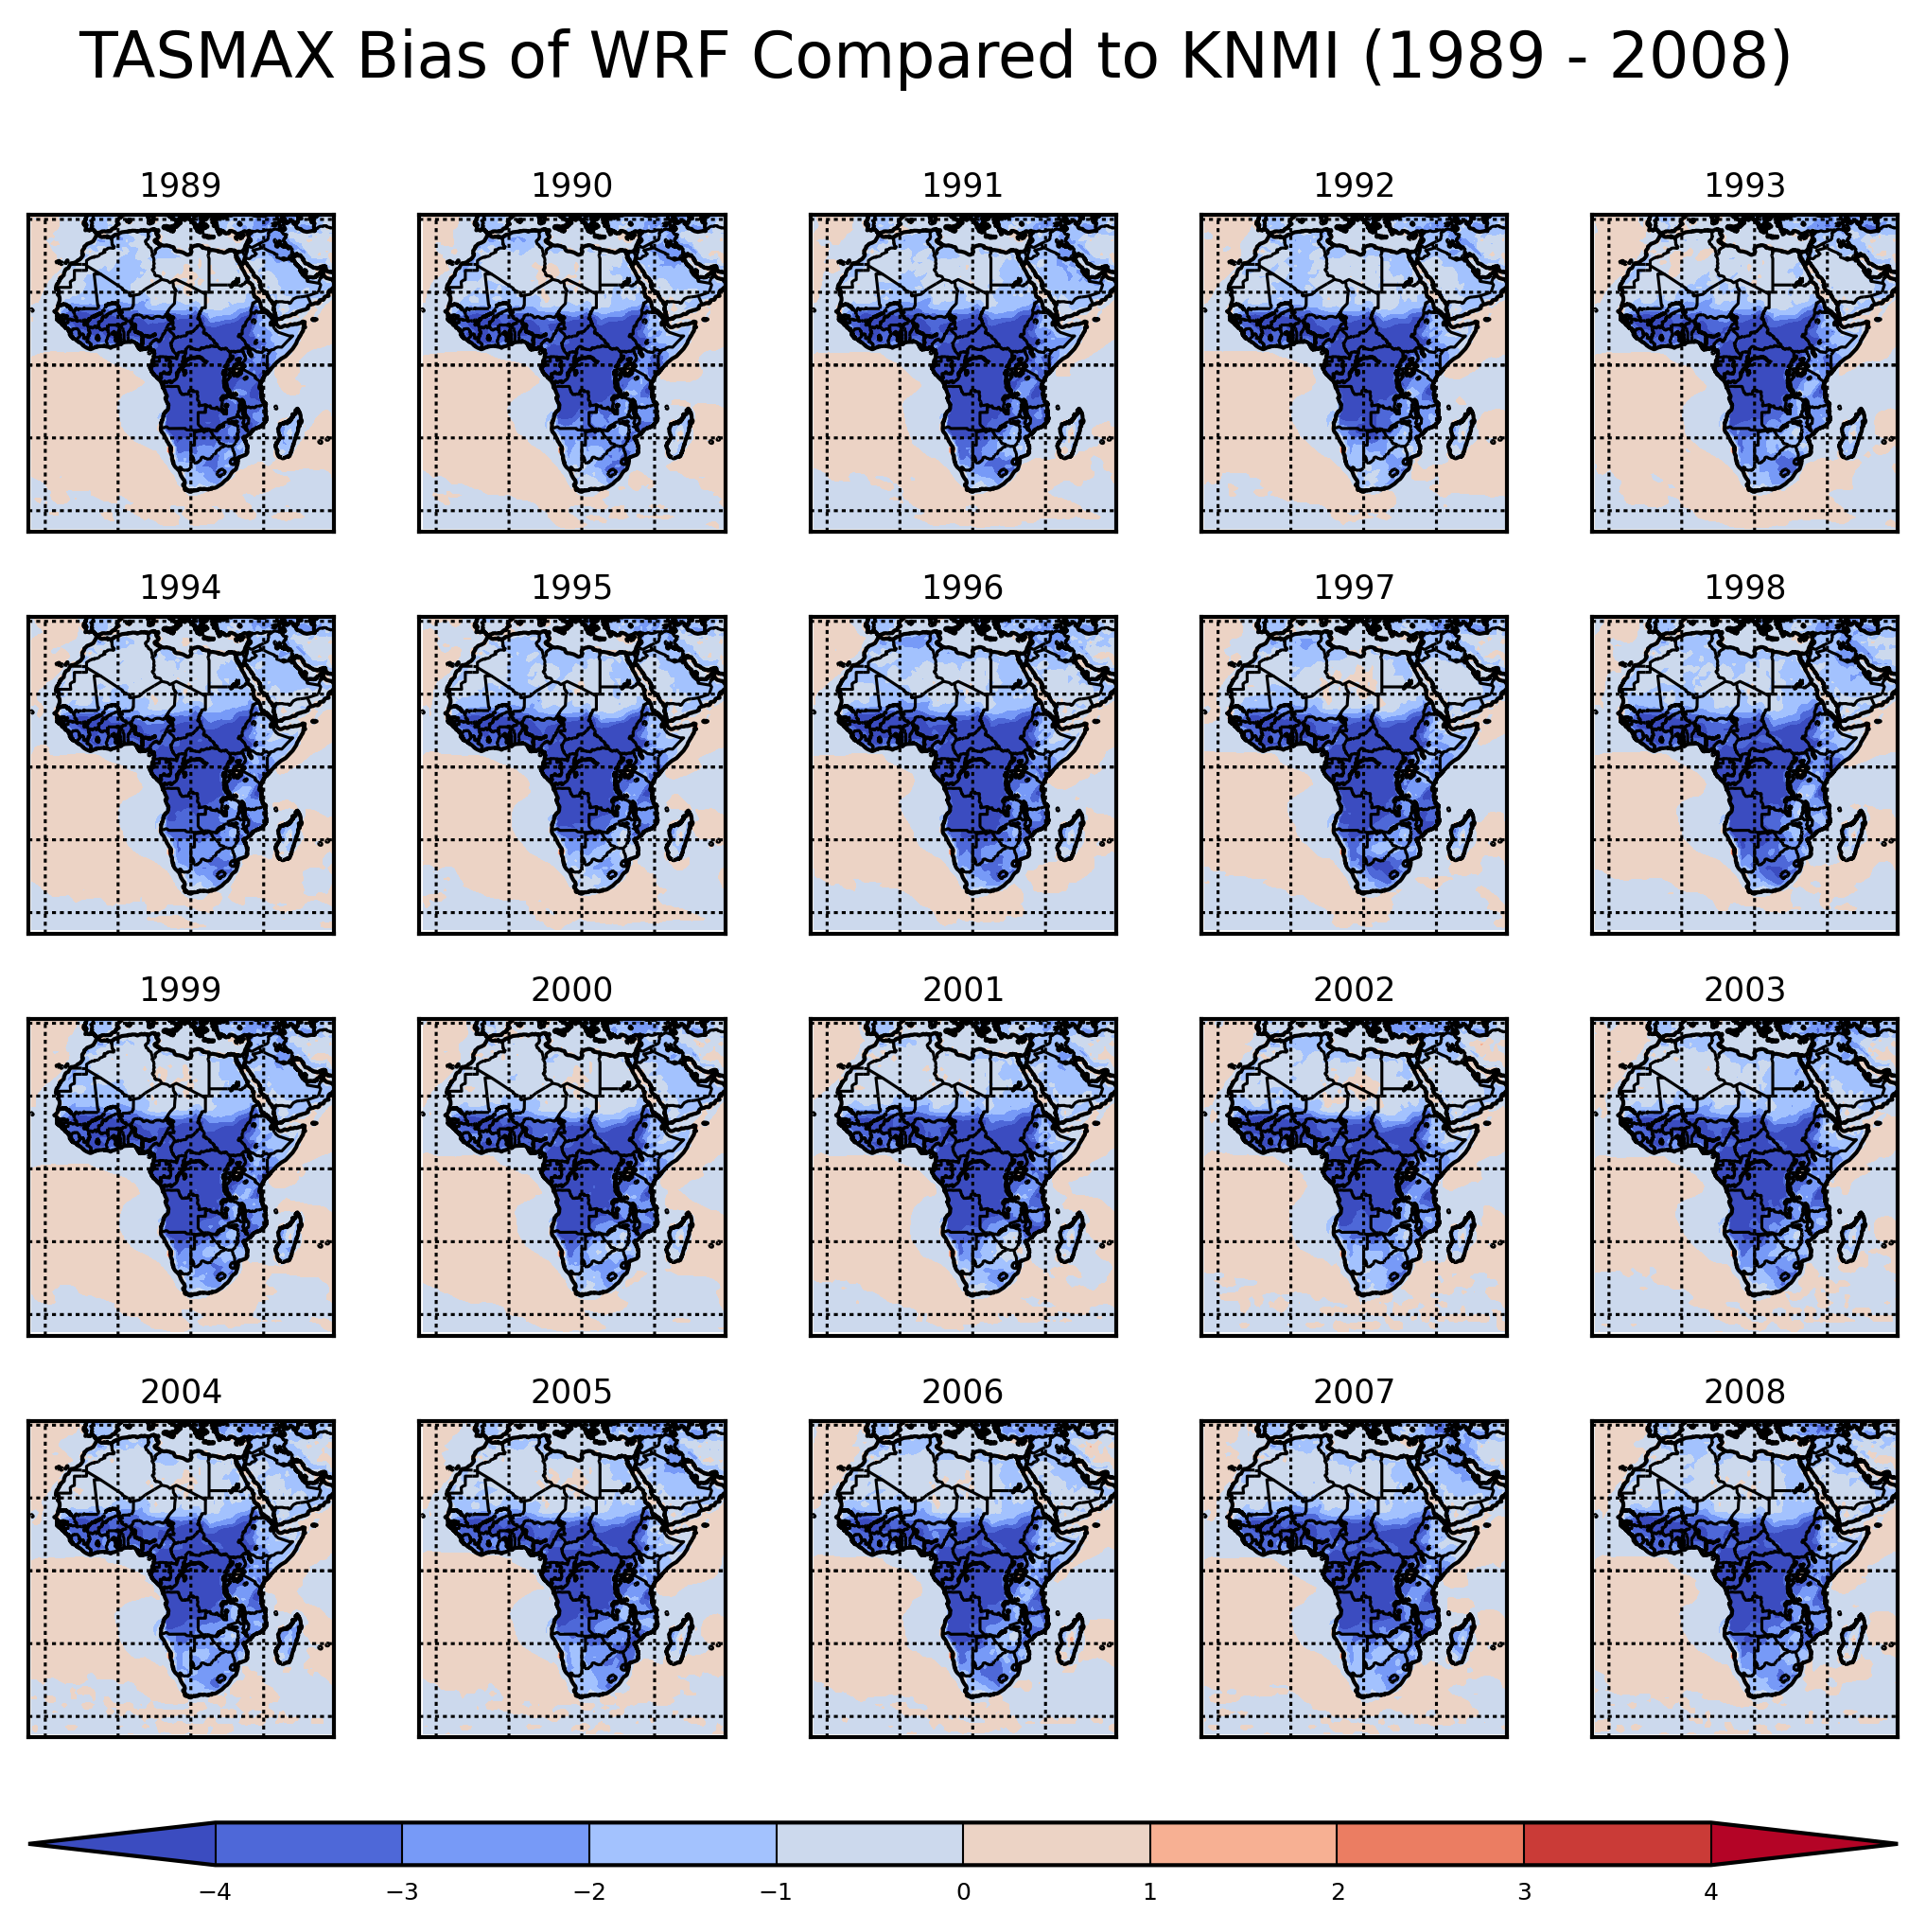

In [5]:
from IPython.display import Image, display

display(Image(plotFile))